### Let's load in all the results and transform them as necessary

In [1]:
import pickle
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from dataclasses import dataclass

@dataclass
class AllSimulationResults:
    emotion_histories: list
    avg_emotions: list
    interventions: list
    G_networks: list
    DG_networks: list
    absorption_dicts: list  # the dictionary version of DG_networks
    initial_conditions: list
    sentiment_graphs: list
    intimacy_matrices: list

In [8]:
populationSize = 15
runs = 13
max_iterations = 260

# No internvention results
all_results_path_plain = r"C:\Users\sescott1\Documents\Simulation Results\09_07_2025\No_Intervention\all_results.pkl"
heatmaps_path_low = r"C:\Users\sescott1\Documents\Simulation Results\09_07_2025\No_Intervention\initial_conditions_heatmaps.pkl"

with open(all_results_path_plain, "rb") as f:
    all_results_wo = pickle.load(f)
with open(all_results_path_plain, "rb") as f:
    heatmaps_wo = pickle.load(f)


# High aperture results
all_results_path_high = r"C:\Users\sescott1\Documents\Simulation Results\09_07_2025\High_Aperture\all_results.pkl"
heatmaps_path_high = r"C:\Users\sescott1\Documents\Simulation Results\09_07_2025\High_Aperture\initial_conditions_heatmaps.pkl"

with open(all_results_path_high, "rb") as f:
    all_results_H = pickle.load(f)
with open(all_results_path_high, "rb") as f:
    heatmaps_H = pickle.load(f)


# Low aperture results
all_results_path_low = r"C:\Users\sescott1\Documents\Simulation Results\09_07_2025\Low_Aperture\all_results.pkl"
heatmaps_path_low = r"C:\Users\sescott1\Documents\Simulation Results\09_07_2025\Low_Aperture\initial_conditions_heatmaps.pkl"
with open(all_results_path_low, "rb") as f:
    all_results_L = pickle.load(f)
with open(all_results_path_low, "rb") as f:
    heatmaps_L = pickle.load(f)

In [9]:
def create_intervention_matrix(all_results):
    '''
    Create a Boolean matrix saying during which timesteps did the leader intervened (0=no, 1=yes) for all simulation runs
    '''
    all_interventions = all_results.interventions
    interventions_summary_df = pd.DataFrame({
        "Run": list(range(1, runs + 1)),
        "Intervention_Timesteps": [','.join(map(str, run)) for run in all_interventions],
        "Num_Interventions": [len(run) for run in all_interventions]
    })

    binary_matrix = np.zeros((runs, max_iterations+1), dtype=int)  # time 0 to 259 for 260 timesteps
    for i, run in enumerate(all_interventions):
        for t in run:
            binary_matrix[i, t] = 1

    interventions_bool_df = pd.DataFrame(binary_matrix).T  # shape: (max_iterations, runs)
    
    return interventions_bool_df, interventions_summary_df

interventions_bool_H, interventions_summary_H = create_intervention_matrix(all_results_H)
interventions_bool_L, interventions_summary_L = create_intervention_matrix(all_results_L)

In [10]:
def create_avg_emotions_matrix(all_results):
    '''
    Convert avg_emotions into a dataframe
    '''
    data = all_results.avg_emotions  # list of lists, one per run
    df_avg_emotions = pd.DataFrame(data).T  # transpose so rows = timesteps, cols = runs
    df_avg_emotions.columns = [f"Run_{i}" for i in range(len(data))]
    df_avg_emotions.insert(0, "Time", df_avg_emotions.index)
    #df_avg_emotions.reset_index(drop=True, inplace=True)
    return df_avg_emotions

dfWithout = create_avg_emotions_matrix(all_results_wo)
dfHigh = create_avg_emotions_matrix(all_results_H)
dfLow = create_avg_emotions_matrix(all_results_L)

In [11]:
# Are High and Low aperture different?
same_matrix = np.array_equal(interventions_bool_H, interventions_bool_L)
print("Boolean intervention matrices identical:", same_matrix)

Boolean intervention matrices identical: False


# Statistical Analysis and Structural Analysis

## Statistics Time!
Remember, our focus is primarily on the dynamics of agent interactions, and how leadership influences those dynamics. We will give a brief explaination of the characteristics to help contextualize the simulation results, but that was what Bosse et al. worked on, so it will not be given as much attention here.

In [12]:
def summarize_interventions(interventions_bool, style_name):
    """
    Summarize the number of interventions per simulation run.
    """
    # Sum interventions per run (column-wise)
    interventions_per_run = interventions_bool.sum(axis=0)
    
    # Minimum excluding 0
    nonzero_min = interventions_per_run[interventions_per_run > 0].min() if np.any(interventions_per_run > 0) else 0
    
    summary_dict = {
        'Style': style_name,
        'Min Interventions (excl 0)': nonzero_min,
        'Max Interventions': interventions_per_run.max(),
        'Average Interventions': interventions_per_run.mean().round()
    }
    
    return pd.DataFrame([summary_dict])

summary_H = summarize_interventions(interventions_bool_H, "High Aperture")
summary_L = summarize_interventions(interventions_bool_L, "Low Aperture")
summary_interventions = pd.concat([summary_H, summary_L], ignore_index=True)
summary_interventions

,Style,Min Interventions (excl 0),Max Interventions,Average Interventions
0,High Aperture,7,249,122.0
1,Low Aperture,12,196,43.0


In [13]:
def runs_with_min_interventions(interventions_bool):
    """
    Returns the indices of runs that have the minimum number of interventions from above.
    """
    interventions_per_run = interventions_bool.sum(axis=0)
    nonzero_min = interventions_per_run[interventions_per_run > 0].min()
    runs_indices = np.where(interventions_per_run == nonzero_min)[0]
    
    return runs_indices.tolist()

runs_H = runs_with_min_interventions(interventions_bool_H)
runs_L = runs_with_min_interventions(interventions_bool_L)

print("High Aperture: runs with min interventions (excl 0) =", runs_H)
print("Low Aperture: runs with min interventions (excl 0) =", runs_L)

High Aperture: runs with min interventions (excl 0) = [5]
Low Aperture: runs with min interventions (excl 0) = [10]


What is it: An extremely brief summary of differences between H vs L | I just wanted to see which simulations corresponded to the minimum intervention out of curiosity

Purpose: To very briefly (superficially?) highlight (or introduce?) the differences between H and L | I want to compare those simulations between the two (for my own curiosity)

Interpretation: The H leader intervenes more on average, though it seems a little interesting that, of all the simulations in which the leaders did intervene, the H leader had the lowest amount of interventions. If we wanted to hypothesize further, one might say this could suggest that early intervention could lead to fewer interventions, but that does not match the other simulation results as the high leader intervened more frequently on average. Therefore, I'd say further analysis on that specific simulation is required as I am wondering if the network structure of that specific simulation may have played a role as to why the H leader did not need to intervene so much. The L leader did not even intervene at all during there time in simulation 5 (avg emo did not meet their threshold during it). We could compare the network structures between the simulations as well and see what, if any, insights that reveals!

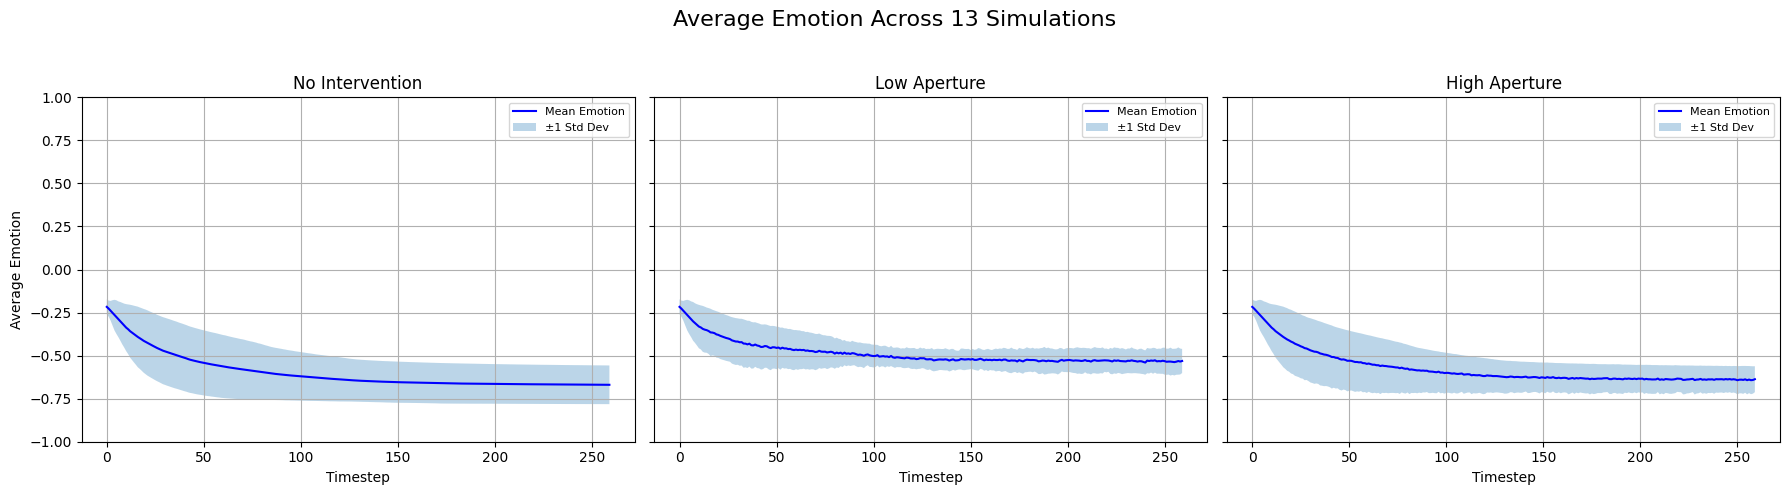

In [14]:
styles = ["No Intervention", "Low Aperture", "High Aperture"]
def plot_avg_emotion_side_by_side(df_list, styles, runs, ylim=(-1, 1), figsize=(18,5)):
    """
    Plot mean emotion per timestep with ±1 standard deviation shading for multiple styles side-by-side.
    """
    n_styles = len(df_list)
    fig, axes = plt.subplots(1, n_styles, figsize=figsize, sharey=True)

    for ax, df, style in zip(axes, df_list, styles):
        mean_emotion = df.iloc[:, 1:].mean(axis=1)
        std_emotion = df.iloc[:, 1:].std(axis=1)

        ax.plot(df.index, mean_emotion, label="Mean Emotion", color='blue')
        ax.fill_between(df.index,
                        mean_emotion - std_emotion,
                        mean_emotion + std_emotion,
                        alpha=0.3, label="±1 Std Dev")
        ax.set_title(style)
        ax.set_xlabel("Timestep")
        ax.grid(True)
        if ax == axes[0]:
            ax.set_ylabel("Average Emotion")
        ax.set_ylim(*ylim)
        ax.legend(loc='upper right', fontsize=8)

    plt.suptitle(f"Average Emotion Across {runs} Simulations", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_avg_emotion_side_by_side([dfWithout, dfHigh, dfLow], styles, runs)

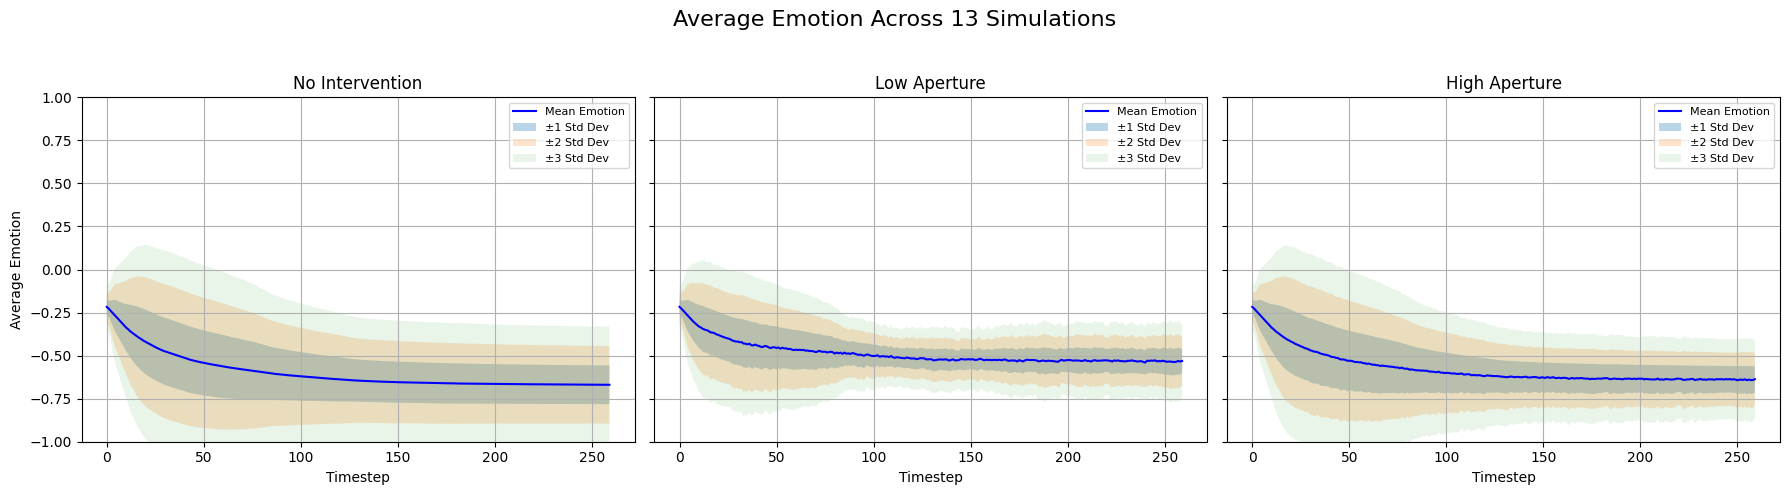

In [15]:
def plot_all_styles_emotion(df_list, style_names, runs, max_std=3):
    """
    Plot average emotion with ±1, ±2, ±3 std deviations for multiple styles in subplots.
    
    df_list : list of DataFrames [dfWithout, dfHigh, dfLow]
    style_names : list of strings ["No Intervention", "High Aperture", "Low Aperture"]
    """
    n_styles = len(df_list)
    fig, axes = plt.subplots(1, n_styles, figsize=(18, 5), sharey=True)

    alphas = [0.3, 0.2, 0.1]

    for ax, df, style in zip(axes, df_list, style_names):
        mean_emotion = df.iloc[:, 1:].mean(axis=1)
        std_emotion = df.iloc[:, 1:].std(axis=1)

        ax.plot(df.index, mean_emotion, label="Mean Emotion", color='blue')

        for i in range(1, max_std+1):
            ax.fill_between(df.index,
                            mean_emotion - i*std_emotion,
                            mean_emotion + i*std_emotion,
                            alpha=alphas[i-1],
                            label=f"±{i} Std Dev")

        ax.set_title(style)
        ax.set_xlabel("Timestep")
        ax.grid(True)
        if ax == axes[0]:
            ax.set_ylabel("Average Emotion")
        ax.set_ylim(-1, 1)
        ax.legend(loc='upper right', fontsize=8)

    plt.suptitle(f"Average Emotion Across {runs} Simulations", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_all_styles_emotion([dfWithout, dfHigh, dfLow], styles, runs)

The above are just the evolution of average emotions with shading indicating standard deviations from the average. The avg emo is not generally representative of individual emos, so we must keep this in mind during any test done using avg emos (unless we want to compare averages across leader types, then in that case maybe it is fine?).

In [17]:
from scipy.stats import ks_2samp, levene, linregress
from sklearn.metrics import auc

def analyze_leader_effects_from_dataclass(results_objects_dict):
    """
    results_objects_dict: dict with keys = style names, values = AllSimulationResults objects
                          e.g., {"No Intervention": all_results_wo_obj, "High Aperture": all_results_H_obj, ...}

    Returns a dictionary with KS, Levene, AUC, and slope results.
    """
    
    # Convert emotion_histories into long-form DataFrame
    records = []
    for style, sim_obj in results_objects_dict.items():
        emotion_histories = sim_obj.emotion_histories
        for run_idx, run in enumerate(emotion_histories):
            for t_idx, timestep in enumerate(run):
                for agent_idx, emotion in enumerate(timestep):
                    records.append({
                        "Run": run_idx,
                        "Timestep": t_idx,
                        "Agent": agent_idx,
                        "Emotion": emotion,
                        "Condition": style
                    })
    df = pd.DataFrame(records)

    # KS test at final timestep
    last_timestep = df['Timestep'].max()
    groups = df[df['Timestep'] == last_timestep].groupby('Condition')['Emotion'].apply(list)
    conditions = groups.index.tolist()
    ks_results = {}
    for i in range(len(conditions)):
        for j in range(i+1, len(conditions)):
            stat, p = ks_2samp(groups[conditions[i]], groups[conditions[j]])
            ks_results[f"{conditions[i]} vs {conditions[j]}"] = {"KS_stat": stat, "p_value": p}
    ks_df = pd.DataFrame(ks_results).T.round(4)

    # Levene's test (variance differences)
    stat, p = levene(*groups)
    levene_df = pd.DataFrame({"Levene_stat": [round(stat,4)], 
                              "p_value": [round(p,4)]})

    # AUC per condition
    auc_list = []
    for cond, group in df.groupby('Condition'):
        mean_curve = group.groupby('Timestep')['Emotion'].mean().sort_index()
        area = auc(mean_curve.index.values, mean_curve.values)
        auc_list.append({"Condition": cond, "AUC": round(area,4)})
    auc_df = pd.DataFrame(auc_list)

    # Slope per condition
    slopes_list = []
    for cond, group in df.groupby('Condition'):
        mean_curve = group.groupby('Timestep')['Emotion'].mean().sort_index()
        slope, intercept, r, p_val, stderr = linregress(mean_curve.index.values, mean_curve.values)
        slopes_list.append({
            "Condition": cond,
            "Slope": round(slope,4),
            "R2": round(r**2,4),
            "p_value": p_val  #round(p_val,4)
        })
    slopes_df = pd.DataFrame(slopes_list)

    return {
        "KS_test_final_timestep": ks_df,
        "Levene_test_final_timestep": levene_df,
        "AUC_results": auc_df,
        "Slopes_results": slopes_df
    }

results_objects_dict = {
    "No Intervention": all_results_wo,
    "High Aperture": all_results_H,
    "Low Aperture": all_results_L
}

results_summary = analyze_leader_effects_from_dataclass(results_objects_dict)
print("KS test (final timestep):\n", results_summary["KS_test_final_timestep"], "\n")
print("Levene's test (final timestep):\n", results_summary["Levene_test_final_timestep"], "\n")
print("AUC results:\n", results_summary["AUC_results"], "\n")
print("Slopes results:\n", results_summary["Slopes_results"], "\n")

KS test (final timestep):
                                   KS_stat  p_value
High Aperture vs Low Aperture      0.2363   0.0001
High Aperture vs No Intervention   0.2527   0.0000
Low Aperture vs No Intervention    0.1264   0.1093 

Levene's test (final timestep):
    Levene_stat  p_value
0       2.1664   0.1156 

AUC results:
          Condition       AUC
0    High Aperture -121.0214
1     Low Aperture -147.4880
2  No Intervention -155.2205 

Slopes results:
          Condition   Slope      R2       p_value
0    High Aperture -0.0006  0.6421  1.006204e-59
1     Low Aperture -0.0009  0.6263  2.781087e-57
2  No Intervention -0.0011  0.6668  9.276245e-64 



What is it: Some non-parametric (not using the average) statistical tests run using individual agent emotions.

- KS: compare distributions among pairs of leader styles (none/H, none/L, H/L) at the end of an evolution (simulation) in order to have an idea of whether we could say that those results came from the "same distribution" meaning whether we can statistically tell a difference when comparing the spread of emotions within those pairs. It tells us whether the emotional differences between agents across leader styles are significant.

- Levene: compare variances across groups (none/H/L) at the end of their evolutions in order to see how spread out the agents' emotions were within each group. Could signify if interventions led to increased emotional stability or not.

- AUC (area under curve): It's telling us how the evolution dynamics across groups were influenced by aperture type (so we can see how high vs low differed in the handling those emotion dynamics, even if a similar or same ending emotional ending was reached). Higher = agents were in higher emos.

- Slopes: This uses linear regression to fit a straight line onto the emotional trajectory for trend estimation (predictability) and tells if emos tended to inc, dec, or stay steady over time. The slope tells us the rate of change of the avg emo, r^2 tells us how well fitted the line is to the actual trajectory, and the p-val tells us how significant the difference of slope - 0 is.

Purpose: To compare the individual agent emotions not using the average to get a different angle on how their dynamics compare accross leadership style (none, low, high)

Interpretation: 

- KS (0,1): The KS values are all <0.3, so the difference between the distribution curves of each group are not very different, but since the p-values for none/H and H/L are both <0.01, the differences that are present may be statistically significant. The none/L p-value is <0.05 but >0.01 (and the KS is smallest at <0.2), so this suggests that even a low-aperture leader could induce some notable impact in the emotional states of their team members.

- Levene: the Levene statistic is ... and the p-value is 0.2288 so the differences in the spread of emotions among the groups seem to indeed be different (at least one group differs from the other two, specifically). From this, we can move on to analyze whether leader intervention increases/decreases emotional alignment among a team. (e.g. if we find that leader intervention dec emo alignment = inc variance = inc polarity :o)

- AUC: The AUC values are all negative which tells us the agents spent most of their time in the negative emotions (unsuprisingly, albeit disappointing). Though, the AUCs of each group are somewhat different with some none vs H being the most different, so this suggests to us that the emotional evolutions of the agents are different when there is intervention vs when there is not.

- Slopes: The slopes are all really small so there is not much great change in the average emotion over time. The R^2 is fairly high at around 0.6 for all three, but if it's using the average emo line, then we already know that's not very representative so I would hesitate to rely on this too much. And the p-values are incredibly small so it just tells us that the results are not just due to noise.

## Structure Time!

We've got two lists of graphs, so keep in mind that the analysis we do might have to be done over all of them

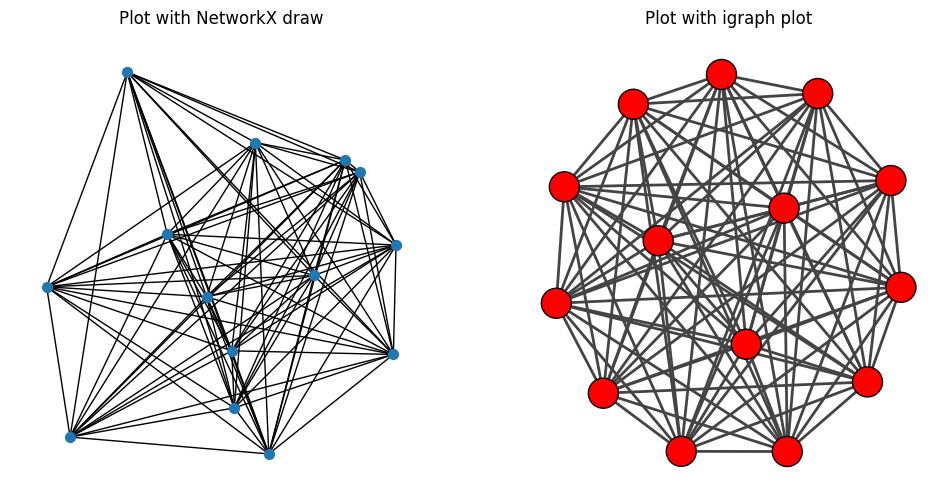

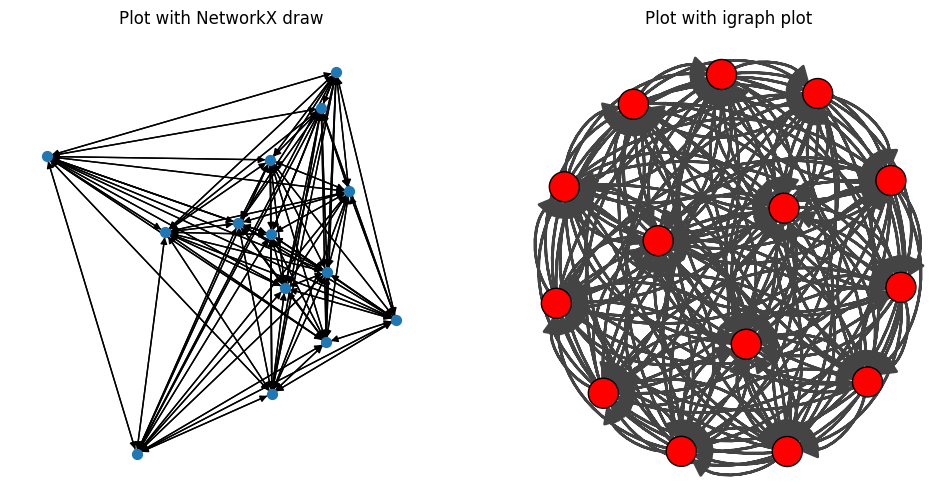

In [18]:
# sample visual
import igraph as ig
networkG = all_results_H.G_networks
networkDG = all_results_H.DG_networks

# convert to igraph
h = ig.Graph.from_networkx(networkG[2])  # using the third run's network for plotting

# Plot the same network with NetworkX and igraph
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# NetworkX draw
ax0.set_title("Plot with NetworkX draw")
nx.draw_kamada_kawai(networkG[2], node_size=50, ax=ax0)

# igraph draw
ax1.set_title("Plot with igraph plot")
layout = h.layout_kamada_kawai()
ig.plot(h, layout=layout, target=ax1)
plt.axis("off")
plt.show()


f = ig.Graph.from_networkx(networkDG[2])  # using the third run's network for plotting

# Plot the same network with NetworkX and igraph
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# NetworkX draw
ax0.set_title("Plot with NetworkX draw")
nx.draw_kamada_kawai(networkDG[2], node_size=50, ax=ax0)

# igraph draw
ax1.set_title("Plot with igraph plot")
layout = f.layout_kamada_kawai()
ig.plot(f, layout=layout, target=ax1)
plt.axis("off")
plt.show()

Focus on edge weights and tools using edge weights

Possible hypotheses:
- Does network structure affect intervention influence?  
***Since only one structure has been used as of yet, bipartite community, this question should be revised if it's to be used in the current paper unless another structure is tested. Alternatively, we could compare tight-bipartite and loose-bipartite (referring to the intra and inter strengths used for the intimacy matrix generation) since that would be quickest to test and compare.***

- Compare starting network and ending network

In [19]:
# I don't like these variable names, but lets just continue
Gs_wo = all_results_wo.G_networks  # list of undirected newtworkx graphs, one per run (interaction frequencies)
Gs_H = all_results_H.G_networks
Gs_L = all_results_L.G_networks
Gs_styles = [Gs_wo, Gs_H, Gs_L]  # for iterating through each style when doing analysis -- list of lists

DGs_wo = all_results_wo.DG_networks  # list of directed newtworkx graphs, one per run (emotion absorption)
DGs_H = all_results_H.DG_networks
DGs_L = all_results_L.DG_networks
DGs_styles = [DGs_wo, DGs_H, DGs_L]

I_wo = all_results_wo.intimacy_matrices  # list of intimacy matrices, one per run
I_H = all_results_H.intimacy_matrices
I_L = all_results_L.intimacy_matrices
I_styles = [I_wo, I_H, I_L]

### Frobenius norm! 
We'll use this to compare simulations within a style to each other to get an idea of how much they vary from each other

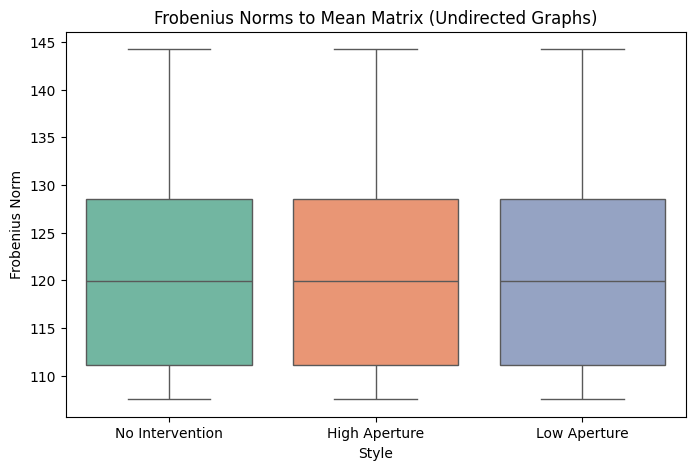

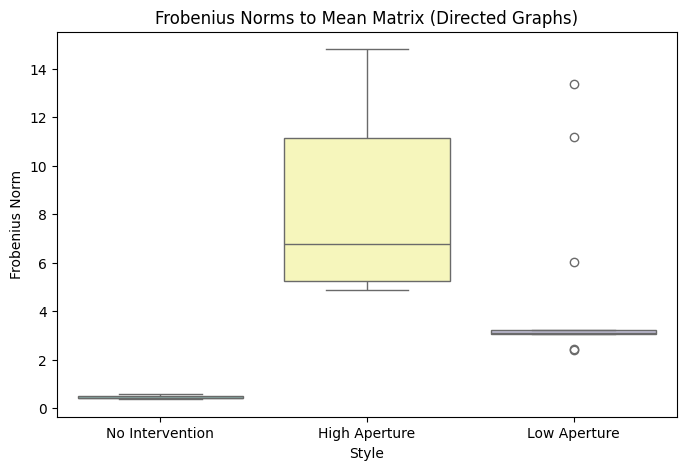

In [ ]:
# Step 1) Convert each network to its adjacency matrix
def graph_to_adj_matrix(graphs_list):
    '''
    Convert a list of NetworkX graphs to their adjacency matrices.
    '''
    adj_matrices = []
    for G in graphs_list:
        A = nx.to_numpy_array(G, weight='weight', dtype=float)  # REMEMBER: for the DG graphs, A_ij = how much i influenced j (so instead of thinking 'how much did j get from i?', think 'how much did i give to j?')
        adj_matrices.append(A)

    return adj_matrices

# for each style of G and DG, apply the function
Gs_wo_adj = graph_to_adj_matrix(Gs_wo)  # list of adjacency matrices, one per run
Gs_H_adj = graph_to_adj_matrix(Gs_H)
Gs_L_adj = graph_to_adj_matrix(Gs_L)
Gs_styles_adj = [Gs_wo_adj, Gs_H_adj, Gs_L_adj]  # list of lists of adjacency matrices

DGs_wo_adj = graph_to_adj_matrix(DGs_wo)
DGs_H_adj = graph_to_adj_matrix(DGs_H)
DGs_L_adj = graph_to_adj_matrix(DGs_L)
DGs_styles_adj = [DGs_wo_adj, DGs_H_adj, DGs_L_adj]


# Step 2) Compute Frobenius norms between each pair of adjacency matrices within a style
def frobenius_norms_comparison(adj_list):
    '''
    We want to compare the adjacency matrices within a style to the mean matrix of that style to get an idea of how much they vary from each other, so we compute the Frobenius norm between each adjacency matrix and the mean matrix. 
    Smaller = more similar
    '''
    mean_matrix = np.mean(adj_list, axis=0)
    frobenius_norms = np.array([np.linalg.norm(A - mean_matrix, 'fro') for A in adj_list])
    return mean_matrix, frobenius_norms

# F norms for G and DG
mean_matrix_G_wo, fnorm_Gs_wo = frobenius_norms_comparison(Gs_wo_adj)
mean_matrix_G_H, fnorm_Gs_H = frobenius_norms_comparison(Gs_H_adj)
mean_matrix_G_L, fnorm_Gs_L = frobenius_norms_comparison(Gs_L_adj)

mean_matrix_DG_wo, fnorm_DGs_wo = frobenius_norms_comparison(DGs_wo_adj)
mean_matrix_DG_H, fnorm_DGs_H = frobenius_norms_comparison(DGs_H_adj)
mean_matrix_DG_L, fnorm_DGs_L = frobenius_norms_comparison(DGs_L_adj)


# Step 3) Visualize the Frobenius norms
styles = ['No Intervention', 'High Aperture', 'Low Aperture']
fnorm_data = {'style': [], 'frobenius_norm': []}

# Undirected graphs
for style_name, fnorms in zip(styles, [fnorm_Gs_wo, fnorm_Gs_H, fnorm_Gs_L]):
    fnorm_data['style'].extend([style_name]*len(fnorms))
    fnorm_data['frobenius_norm'].extend(fnorms)

df_fnorm = pd.DataFrame(fnorm_data)

plt.figure(figsize=(8,5))
sns.boxplot(x='style', y='frobenius_norm', data=df_fnorm, palette='Set2', hue='style', legend=False)
plt.title("Frobenius Norms to Mean Matrix (Undirected Graphs)")
plt.ylabel("Frobenius Norm")
plt.xlabel("Style")
plt.show()


# Directed graphs
fnorm_data_dir = {'style': [], 'frobenius_norm': []}
for style_name, fnorms in zip(styles, [fnorm_DGs_wo, fnorm_DGs_H, fnorm_DGs_L]):
    fnorm_data_dir['style'].extend([style_name]*len(fnorms))
    fnorm_data_dir['frobenius_norm'].extend(fnorms)

df_fnorm_dir = pd.DataFrame(fnorm_data_dir)

plt.figure(figsize=(8,5))
sns.boxplot(x='style', y='frobenius_norm', data=df_fnorm_dir, palette='Set3', hue='style', legend=False)
plt.title("Frobenius Norms to Mean Matrix (Directed Graphs)")
plt.ylabel("Frobenius Norm")
plt.xlabel("Style")
plt.show()

### Coarse-grained Analysis
We're using the mean matrices for the G-interaction and DG-absorption graphs. We can do a fine-grained analysis to focus more on the initial conditions of agent parameters, but for now our focus is on **leader intervention** and network structure (which we deliberately created)

In [ ]:
# Are the mean matrices for the G and DG graphs the same for High and Low Aperture?
print(f"G's identical: {np.array_equal(mean_matrix_G_H, mean_matrix_G_L)}")
print(f"DG's identical: {np.array_equal(mean_matrix_DG_H, mean_matrix_DG_L)}")

G's identical: True
DG's identical: False


Huh, that's interesting

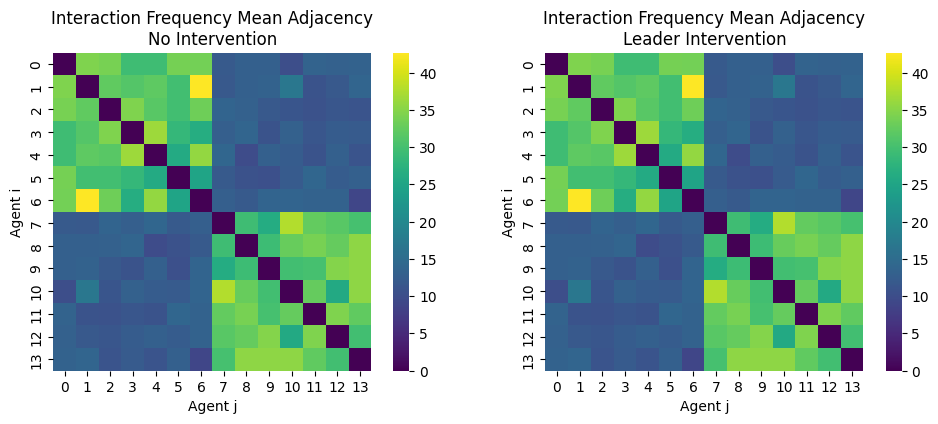

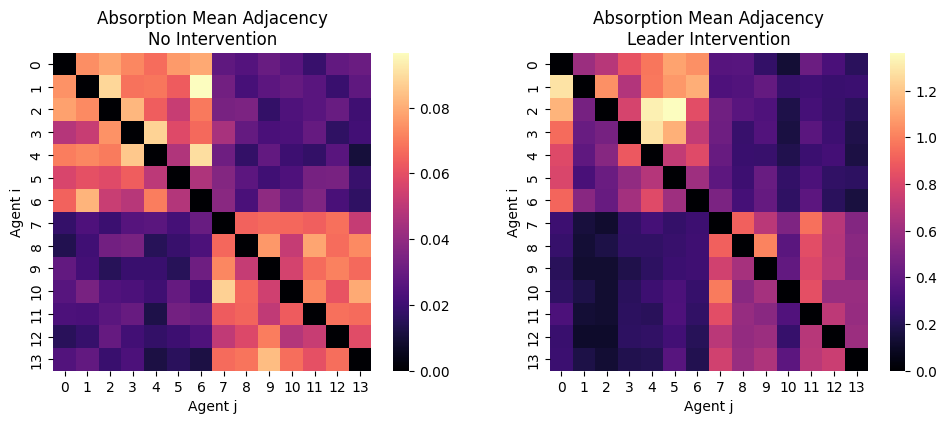

In [ ]:
# Heatmaps to visualize the mean adjacency matrices for G and DG graphs
# Mean matrices from earlier
styles = ['No Intervention', 'Leader Intervention']  # using general intervention since they are identical
mean_matrix_G_HL = mean_matrix_G_H
mean_matrix_DG_HL = mean_matrix_DG_H

mean_matrices_G = [mean_matrix_G_wo, mean_matrix_G_HL]
mean_matrices_DG = [mean_matrix_DG_wo, mean_matrix_DG_HL]

# Plot G graphs (interaction frequencies)
plt.figure(figsize=(15,4))
for i, (style, mat) in enumerate(zip(styles, mean_matrices_G)):
    plt.subplot(1, 3, i+1)
    sns.heatmap(mat, cmap='viridis', square=True)
    plt.title(f'Interaction Frequency Mean Adjacency\n{style}')
    plt.xlabel('Agent j')
    plt.ylabel('Agent i')
plt.tight_layout()
plt.show()

# Plot DG graphs (emotion absorption)
plt.figure(figsize=(15,4))
for i, (style, mat) in enumerate(zip(styles, mean_matrices_DG)):
    plt.subplot(1, 3, i+1)
    sns.heatmap(mat, cmap='magma', square=True)
    plt.title(f'Absorption Mean Adjacency\n{style}')
    plt.xlabel('Agent j')
    plt.ylabel('Agent i')
plt.tight_layout()
plt.show()

In [ ]:
# Clustering coefficient for community detection verification
def weighted_clustering_coefficient(adj_matrix, directed=False):
    """
    Compute the average weighted clustering coefficient for a graph represented by an adjacency matrix.
    """
    if directed:
        # Convert directed to undirected for clustering purposes
        G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
        G_undirected = G.to_undirected()
    else:
        G_undirected = nx.from_numpy_array(adj_matrix)

    # Compute weighted clustering coefficient per node
    clustering_dict = nx.clustering(G_undirected, weight='weight')
    avg_clustering = np.mean(list(clustering_dict.values()))
    return avg_clustering


# Undirected graphs (interaction frequency)
avg_clust_G_wo = weighted_clustering_coefficient(mean_matrix_G_wo, directed=False)
avg_clust_G_HL  = weighted_clustering_coefficient(mean_matrix_G_HL, directed=False)

# Directed graphs (emotion absorption)
avg_clust_DG_wo = weighted_clustering_coefficient(mean_matrix_DG_wo, directed=True)
avg_clust_DG_HL  = weighted_clustering_coefficient(mean_matrix_DG_HL, directed=True)

print("                             No Intervention  Leader Intervention")
print("Weighted clustering (G)  :", avg_clust_G_wo,  avg_clust_G_HL)
print("Weighted clustering (DG) :", avg_clust_DG_wo, avg_clust_DG_HL)

                             No Intervention  Leader Intervention
Weighted clustering (G)  : 0.4621506497118693 0.4621506497118693
Weighted clustering (DG) : 0.42873125795461103 0.28984815359020916


Intervention has no affect on the interaction patterns amongst agents (as we saw in the first box-whisker plot).

Intervention has some affect when it comes to the dynamics of emotional absorption though, so there is some interference there. This suggests that intervention interrupts (local patterns of?) emotional influence among agents! something something "the propagation of emotions"

In [ ]:
# Centrality measures to identify key agents
def compute_centrality_measures(G_mean, DG_mean):
    """
    Compute weighted closeness and betweenness centrality for both G (undirected) and DG (directed) mean matrices.
    Returns the mean centrality values per style.
    """
    # Convert numpy adjacency matrices back to NetworkX graphs
    G_graph = nx.from_numpy_array(G_mean, create_using=nx.Graph())
    DG_graph = nx.from_numpy_array(DG_mean, create_using=nx.DiGraph())

    # Weighted closeness centrality
    closeness_G = nx.closeness_centrality(G_graph, distance='weight')
    closeness_DG = nx.closeness_centrality(DG_graph, distance='weight')

    # Weighted betweenness centrality
    betweenness_G = nx.betweenness_centrality(G_graph, weight='weight', normalized=True)
    betweenness_DG = nx.betweenness_centrality(DG_graph, weight='weight', normalized=True)

    # Mean values across all nodes
    mean_values = {
        'closeness_G': np.mean(list(closeness_G.values())),
        'closeness_DG': np.mean(list(closeness_DG.values())),
        'betweenness_G': np.mean(list(betweenness_G.values())),
        'betweenness_DG': np.mean(list(betweenness_DG.values()))
    }
    return mean_values

centrality_no_intervention = compute_centrality_measures(mean_matrix_G_wo, mean_matrix_DG_wo)
centrality_leader_intervention = compute_centrality_measures(mean_matrix_G_H, mean_matrix_DG_H)

# For pretty printing
centrality_df = pd.DataFrame({
    'No Intervention': centrality_no_intervention,
    'Leader Intervention': centrality_leader_intervention
}).T  # transpose so styles are rows
centrality_df = centrality_df.round(4)  # rounding for readability

print(centrality_df)

                     closeness_G  closeness_DG  betweenness_G  betweenness_DG
No Intervention           0.0595       33.6913         0.0385          0.0385
Leader Intervention       0.0595        3.1906         0.0385          0.0375


In [28]:
def compute_per_agent_centralities(adj_list, directed=False):
    """
    Compute closeness and betweenness centralities for each agent in each simulation.
    Returns a list of dicts (one per simulation) for closeness and betweenness.
    """
    all_closeness = []
    all_betweenness = []
    
    for A in adj_list:
        if directed:
            G = nx.from_numpy_array(A, create_using=nx.DiGraph)
        else:
            G = nx.from_numpy_array(A)
        
        closeness = nx.closeness_centrality(G, distance='weight')
        betweenness = nx.betweenness_centrality(G, weight='weight')
        all_closeness.append(closeness)
        all_betweenness.append(betweenness)
    
    return all_closeness, all_betweenness

def per_agent_centrality_summary(adj_styles, style_names, directed=False):
    """
    Computes per-agent centralities for multiple styles.
    Returns a dict of DataFrames: keys are style names, values are DataFrames with agents as columns,
    simulations as rows.
    """
    summary = {}
    for adj_list, style in zip(adj_styles, style_names):
        closeness_list, betweenness_list = compute_per_agent_centralities(adj_list, directed=directed)
        df_closeness = pd.DataFrame(closeness_list)
        df_betweenness = pd.DataFrame(betweenness_list)
        summary[style] = {'closeness': df_closeness, 'betweenness': df_betweenness}
    return summary

G_styles = [Gs_wo_adj, Gs_H_adj]  # since H and L are identical, just pick one for intervention
G_centrality_summary = per_agent_centrality_summary(G_styles, styles, directed=False)

DG_styles = [DGs_wo_adj, DGs_H_adj]
DG_centrality_summary = per_agent_centrality_summary(DG_styles, styles, directed=True)

def agent_centrality_overview(summary_dict):
    """
    Compute per-agent mean and std for closeness and betweenness across simulations.
    Identify top agents (highest centrality) for focus.
    """
    for style, metrics in summary_dict.items():
        print(f"\n=== {style} ===")
        
        # Compute mean and std across simulations
        mean_closeness = metrics['closeness'].mean()
        std_closeness = metrics['closeness'].std()
        mean_betweenness = metrics['betweenness'].mean()
        std_betweenness = metrics['betweenness'].std()
        
        overview_df = pd.DataFrame({
            'Closeness_mean': mean_closeness.round(4),
            'Closeness_std': std_closeness.round(4),
            'Betweenness_mean': mean_betweenness.round(4),
            'Betweenness_std': std_betweenness.round(4)
        })
        
        print("Per-agent summary (mean ± std):")
        print(overview_df)
        
        # Highlight top 2 agents by mean closeness and betweenness
        top_closeness = overview_df['Closeness_mean'].nlargest(2)
        top_betweenness = overview_df['Betweenness_mean'].nlargest(2)
        
        print("\nAgents to focus on:")
        print("Top closeness:", list(top_closeness.index))
        print("Top betweenness:", list(top_betweenness.index))

print("Undirected Graphs (Interaction frequency):")
agent_centrality_overview(G_centrality_summary)

print("\nDirected Graphs (Emotion absorption):")
agent_centrality_overview(DG_centrality_summary)

Undirected Graphs (Interaction frequency):

=== No Intervention ===
Per-agent summary (mean ± std):
    Closeness_mean  Closeness_std  Betweenness_mean  Betweenness_std
0           0.0854         0.0167            0.0662           0.0708
1           0.0773         0.0097            0.0327           0.0344
2           0.0848         0.0090            0.0634           0.0485
3           0.0807         0.0092            0.0281           0.0322
4           0.0842         0.0099            0.0653           0.0590
5           0.0868         0.0094            0.0618           0.0487
6           0.0835         0.0130            0.0616           0.0586
7           0.0817         0.0164            0.0585           0.0776
8           0.0868         0.0150            0.0672           0.0643
9           0.0833         0.0122            0.0457           0.0608
10          0.0808         0.0159            0.0437           0.0476
11          0.0849         0.0113            0.0549           0.0368
12 

We can interpret that later

In [29]:
# Undirected (weighted degree assortativity)
assort_G_wo = nx.degree_pearson_correlation_coefficient(
    nx.from_numpy_array(mean_matrix_G_wo), weight='weight')
assort_G_H = nx.degree_pearson_correlation_coefficient(
    nx.from_numpy_array(mean_matrix_G_H), weight='weight')

# Directed (weighted degree assortativity)
assort_DG_wo = nx.degree_pearson_correlation_coefficient(
    nx.from_numpy_array(mean_matrix_DG_wo, create_using=nx.DiGraph), weight='weight')
assort_DG_H = nx.degree_pearson_correlation_coefficient(
    nx.from_numpy_array(mean_matrix_DG_H, create_using=nx.DiGraph), weight='weight')

assortativity_results = {
    'Graph Type': ['Undirected (G)', 'Undirected (G)', 'Directed (DG)', 'Directed (DG)'],
    'Style': ['No Intervention', 'Leader Intervention', 'No Intervention', 'Leader Intervention'],
    'Weighted Degree Pearson r': [
        assort_G_wo, assort_G_H,
        assort_DG_wo, assort_DG_H
    ]
}

df_assortativity = pd.DataFrame(assortativity_results)
print(df_assortativity.round(4))

       Graph Type                Style  Weighted Degree Pearson r
0  Undirected (G)      No Intervention                    -0.0769
1  Undirected (G)  Leader Intervention                    -0.0769
2   Directed (DG)      No Intervention                     0.0063
3   Directed (DG)  Leader Intervention                     0.0279


In [30]:
from itertools import combinations

def count_motifs(G, motif_size, directed=False):
    """
    Counts all unique motifs of a given size in a graph.
    
    Parameters:
        G : NetworkX graph (directed or undirected)
        motif_size : int, number of nodes in the motif
        directed : bool, True if graph is directed
    
    Returns:
        motif_counts : dict, keys are motif adjacency tuples, values are counts
    """
    motif_counts = {}
    nodes = list(G.nodes())
    
    for node_combo in combinations(nodes, motif_size):
        subgraph = G.subgraph(node_combo)
        # adjacency tuple to make it hashable
        adj_tuple = tuple(nx.to_numpy_array(subgraph, dtype=int).flatten())
        motif_counts[adj_tuple] = motif_counts.get(adj_tuple, 0) + 1
    
    return motif_counts

G_mean = nx.from_numpy_array(mean_matrix_G_wo)
motifs_G = count_motifs(G_mean, motif_size=3, directed=False)
DG_mean = nx.from_numpy_array(mean_matrix_DG_H, create_using=nx.DiGraph)
motifs_DG = count_motifs(DG_mean, motif_size=3, directed=True)


def motifs_to_df(motif_counts):
    """
    Convert motif count dictionary to a pretty DataFrame sorted by count.
    """
    df = pd.DataFrame([
        {'motif': k, 'count': v} for k, v in motif_counts.items()
    ])
    df = df.sort_values(by='count', ascending=False).reset_index(drop=True)
    return df

# Undirected graph motifs
df_motifs_G = motifs_to_df(motifs_G)
print("=== Undirected Graph Motifs ===")
print(df_motifs_G.head(10))  # show top 10

# Directed graph motifs
df_motifs_DG = motifs_to_df(motifs_DG)
print("\n=== Directed Graph Motifs ===")
print(df_motifs_DG.head(10))  # show top 10


=== Undirected Graph Motifs ===
                               motif  count
0  (0, 11, 29, 11, 0, 12, 29, 12, 0)      5
1  (0, 32, 12, 32, 0, 13, 12, 13, 0)      4
2  (0, 34, 13, 34, 0, 11, 13, 11, 0)      4
3  (0, 34, 13, 34, 0, 13, 13, 13, 0)      4
4  (0, 29, 13, 29, 0, 12, 13, 12, 0)      4
5  (0, 13, 33, 13, 0, 13, 33, 13, 0)      4
6  (0, 29, 13, 29, 0, 11, 13, 11, 0)      3
7  (0, 13, 29, 13, 0, 12, 29, 12, 0)      3
8  (0, 13, 32, 13, 0, 12, 32, 12, 0)      3
9  (0, 13, 13, 13, 0, 34, 13, 34, 0)      3

=== Directed Graph Motifs ===
                         motif  count
0  (0, 0, 0, 0, 0, 0, 0, 0, 0)    242
1  (0, 1, 0, 0, 0, 0, 0, 0, 0)     35
2  (0, 0, 1, 0, 0, 0, 0, 0, 0)     34
3  (0, 0, 0, 0, 0, 1, 0, 0, 0)     19
4  (0, 0, 0, 1, 0, 0, 0, 0, 0)     15
5  (0, 1, 1, 0, 0, 0, 0, 0, 0)      5
6  (0, 0, 1, 0, 0, 1, 0, 0, 0)      4
7  (0, 0, 1, 1, 0, 1, 0, 0, 0)      3
8  (0, 0, 0, 0, 0, 0, 1, 0, 0)      2
9  (0, 0, 0, 1, 0, 1, 1, 0, 0)      1


In [31]:
def compute_weighted_strength(graphs, directed=False):
    results = []
    for G in graphs:
        if directed:
            # DG_graphs should be passed here instead of G_graphs
            df = pd.DataFrame({
                'in_strength': dict(G.in_degree(weight='weight')).values(),
                'out_strength': dict(G.out_degree(weight='weight')).values()
            }, index=G.nodes)
        else:
            df = pd.DataFrame({
                'strength': dict(G.degree(weight='weight')).values()
            }, index=G.nodes)
        results.append(df)
    return results

def compute_weighted_clustering(graphs):
    """
    Returns a list of Series with weighted clustering coefficient per node.
    Works for both directed and undirected graphs.
    """
    clustering_list = []
    for G in graphs:
        clustering_list.append(nx.clustering(G, weight='weight'))
    return clustering_list

def compute_weighted_centrality(graphs, directed=True):
    """
    Returns dictionaries with closeness and betweenness centrality for each graph.
    """
    results_list = []
    for G in graphs:
        # For closeness, define distance as 1/weight so stronger intimacy = shorter distance
        length_dict = {}
        for u, v, d in G.edges(data=True):
            # avoid divide by zero
            d['distance'] = 1.0 / max(d.get('weight', 1e-6), 1e-6)
        closeness = nx.closeness_centrality(G, distance='distance')
        betweenness = nx.betweenness_centrality(G, weight='weight')
        results_list.append({'closeness': closeness, 'betweenness': betweenness})
    return results_list

def compute_weighted_assortativity(graphs):
    """
    Returns a list of weighted assortativity coefficients (degree-based).
    """
    assortativity_list = []
    for G in graphs:
        assortativity_list.append(nx.degree_pearson_correlation_coefficient(G, weight='weight'))
    return assortativity_list

def compute_weighted_triangles(graphs):
    """
    Returns a list with number of triangles weighted by edge weights for each node.
    """
    triangles_list = []
    for G in graphs:
        triangles_list.append(nx.triangles(G))  # Note: triadic counts ignore weights; for weighted, could use sum of weights in triads
    return triangles_list

def summarize_edge_weights(graphs):
    """
    Returns a DataFrame summarizing min, max, mean, std of edge weights per graph.
    """
    summary_list = []
    for i, G in enumerate(graphs):
        weights = [d['weight'] for u, v, d in G.edges(data=True)]
        df = pd.DataFrame({
            'graph_id': [i],
            'min_weight': [min(weights)],
            'max_weight': [max(weights)],
            'mean_weight': [sum(weights)/len(weights)],
            'std_weight': [pd.Series(weights).std()]
        })
        summary_list.append(df)
    return pd.concat(summary_list, ignore_index=True)

In [32]:
def full_network_analysis(batch_dict):
    """
    batch_dict: dictionary of the form
        {
            'wo': all_results_wo,
            'H': all_results_H,
            'L': all_results_L
        }
    Each value should have G_networks and DG_networks lists.
    
    Returns:
        analysis_results: nested dictionary with each measure per batch
    """
    analysis_results = {}

    for label, results in batch_dict.items():
        analysis_results[label] = {}

        G_graphs = results.G_networks
        DG_graphs = results.DG_networks

        # Weighted Strength
        analysis_results[label]['weighted_strength'] = compute_weighted_strength(G_graphs, directed=False)
        analysis_results[label]['weighted_strength_directed'] = compute_weighted_strength(DG_graphs, directed=True)


        # Weighted Clustering
        analysis_results[label]['weighted_clustering'] = compute_weighted_clustering(G_graphs)

        # Weighted Centrality
        analysis_results[label]['weighted_centrality'] = compute_weighted_centrality(DG_graphs, directed=True)

        # Weighted Assortativity
        analysis_results[label]['weighted_assortativity'] = compute_weighted_assortativity(G_graphs)

        # Weighted Triangles
        analysis_results[label]['weighted_triangles'] = compute_weighted_triangles(G_graphs)

        # Edge Weight Summary
        analysis_results[label]['edge_weight_summary'] = summarize_edge_weights(G_graphs)

    return analysis_results

In [33]:
batches = {
    'wo': all_results_wo,
    'H': all_results_H,
    'L': all_results_L
}

analysis_results = full_network_analysis(batches)

In [34]:
for label, results in analysis_results.items():
    print(f"\nBatch: {label}")
    print(results['edge_weight_summary'])



Batch: wo
    graph_id  min_weight  max_weight  mean_weight  std_weight
0          0           3          63    21.285714   12.899858
1          1           2          59    20.956044   14.101940
2          2           1          56    20.780220   13.424523
3          3           1          61    21.417582   13.584359
4          4           2          65    22.373626   14.657306
5          5           1          52    22.010989   13.547853
6          6           1          55    21.989011   14.254430
7          7           3          68    21.153846   13.874776
8          8           1          53    20.879121   13.016942
9          9           1          62    21.648352   13.548574
10        10           1          82    21.109890   14.195814
11        11           1          52    21.263736   12.253648
12        12           2          64    21.010989   13.449903

Batch: H
    graph_id  min_weight  max_weight  mean_weight  std_weight
0          0           3          63    21.285714

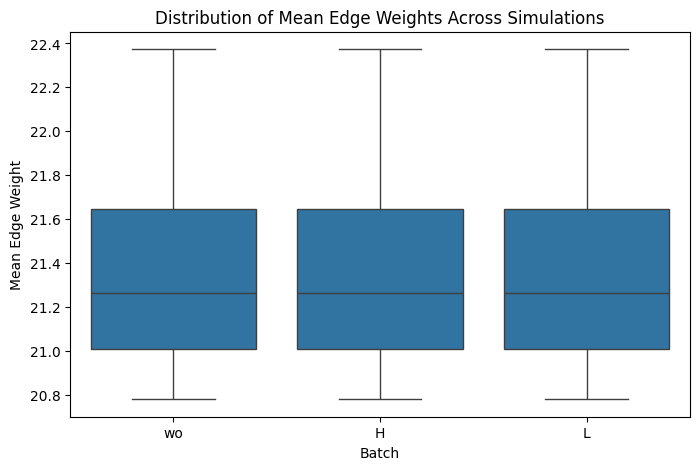

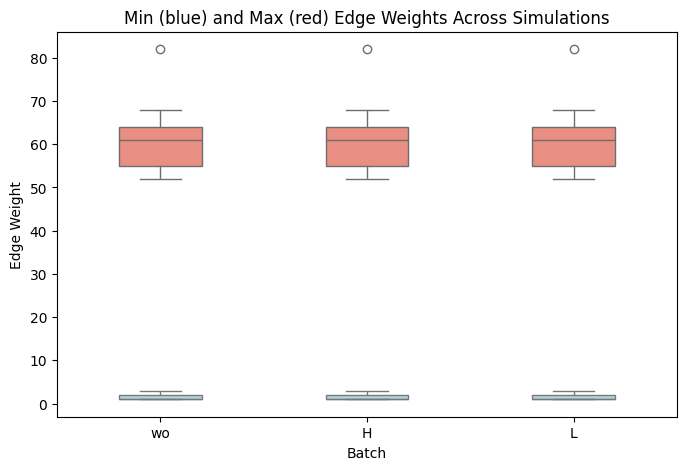

In [35]:
# Collect all edge weight summaries into one DataFrame with a batch label
all_summaries = []

for label, results in analysis_results.items():
    df = results['edge_weight_summary'].copy()
    df['batch'] = label
    all_summaries.append(df)

summary_df = pd.concat(all_summaries, ignore_index=True)

# Plot boxplots of mean edge weights per batch
plt.figure(figsize=(8,5))
sns.boxplot(x='batch', y='mean_weight', data=summary_df)
plt.title("Distribution of Mean Edge Weights Across Simulations")
plt.ylabel("Mean Edge Weight")
plt.xlabel("Batch")
plt.show()

# Optional: also plot min and max weights if you want full range comparison
plt.figure(figsize=(8,5))
sns.boxplot(x='batch', y='min_weight', data=summary_df, color='lightblue', width=0.4)
sns.boxplot(x='batch', y='max_weight', data=summary_df, color='salmon', width=0.4)
plt.title("Min (blue) and Max (red) Edge Weights Across Simulations")
plt.ylabel("Edge Weight")
plt.xlabel("Batch")
plt.show()
